<a href="https://colab.research.google.com/github/Ryota0829/deep_learning_Classification_driving/blob/master/SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **物体検出　SSD（Single Shot MultiBox Detector）**

## **1. 物体検出とは**

### 物体検出の概要

物体検出とは１枚の画像中に含まれている複数の物体に対して、物体の**領域**と**物体名**を想定するタスク
> つまり、画像のどこに何が写っているのかを明らかにする。

### 物体検出タスクのインプットとアウトプット

- インプット：画像
- アウトプットは３種類の画像
    1. 画像のどこに物体が存在するのかを示すBounding Boxと呼ばれる枠の位置と範囲情報
    2. 各Bounding Boxが何の物体であるかを示すラベル情報
    3. その検出に対する信頼度（confidence）

>物体検出では信頼度の高いBounding Boxのみを最終的にアウトプットする。

### SSDによる物体検出の大まかな流れ

1. 入力画像の大きさを300×300ピクセルにリサイズして入力を行う。(SSD300)実際には色情報の標準化も行う。
> 512×512ピクセルで処理するSSD512もある。
2. 物体のBounding Boxを求める際に、Bounding Boxの情報を出力させるのではなく**default Box**と呼ばれる様々なアスペクト比の長方形を予め用意しておく。
> SSD300の場合8732個のdefault Boxを用意
3. **default Box**をどのように変形させれば、Bounding Boxになるのかという情報を出力させる。(オフセット情報)
> Bounding Boxの情報が$(cx_d, cy_d, w_d, h_d)$であった場合、オフセット情報は$(\Delta cx, \Delta cy, \Delta w, \Delta h)$の4変数となり,
$$
    cx = cx_d(1+0.1\Delta cx)\\
    cy = cy_d(1+0.1\Delta cy)\\
    w = w_d×exp(0.2\Delta w)\\
    h = h_d×exp(0.2\Delta h)
$$
として計算される。なお計算式は理論的に導出されるわけではなく、SSDではこのように定めてモデルを学習させる、という理由から上記の計算式が出現する。\
default Box8732個　×（オフセット情報4個＋各クラスの信頼度）=　出力させる情報量
4. default Box8732個のうち信頼度の高いものを上位からtop_k個(SSD300では200個)取り出す。
> default Boxに対応するラベルは各ラベルの中でも信頼度が最も高いクラスになる
5. オフセット情報を使用し、default BoxをBounding Boxに変形。
> ここで手順４で取り出したtop_k個のdefault BoxのうちBounding Boxの重なりが大きいもの（つまり、同一の物体を検出していると思われるもの）が複数ある場合は、最も信頼度が高いBounding Boxのみを残す。
6. 最終的なBounding Boxとそのラベルを出力する。
> 信頼度の閾値を決め、閾値以上の信頼度をもつBounding Boxのみを最終出力とする\
誤検出を避けたい場合は高い閾値を設定し、未検出を避けたい場合は低い閾値を設定する。

## **2. Datasetの実装**

### Pytorchによるディープラーニング実装の大まかな流れ

1. 前処理、後処理、そしてネットワークモデルの入出力を確認
2. Datasetの作成
3. DataLoaderの作成
4. ネットワークモデルの作成
5. 順伝播（forward）の定義
6. 損失関数の定義
7. 最適化手法の設定
8. 学習・検証の実施
9. テストデータで推論

### ユーザ認証

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### ディレクトリの確認と変更

In [2]:
ls

drive/  sample_data/


In [3]:
pwd

'/content'

In [8]:
cd /content/drive/My\ Drive/Colab Notebooks/SSD/ 

/content/drive/My Drive/Colab Notebooks/SSD


### 画像データ、アノテーションデータへのファイルパスのリストを作成

物体検出のDatasetと画像分類の大きな違いはアノテーションデータの存在
> 画像分類：ファイル名やフォルダ名にクラス名が含まれており、答えとなるデータ（アノテーションデータ）は存在しない\
物体検出：物体位置とラベルの答えとなるアノテーション（Bounding Boxの情報）データが存在する
>> 物体検出ではDataSetで画像データと一緒にアノテーションデータを扱う必要がある。\
画像の前処理や訓練時のデータオーギュメンテーションで入力画像のサイズが変更される際にアノテーションデータのBounding Box情報も合わせて変更する必要がある

In [0]:
# パッケージのimport
import os.path as osp
import numpy as np
import cv2
import random

# XMLをファイルやテキストから読み込んだり、加工したり、保存したりするためのライブラリ
import xml.etree.ElementTree as ET

import torch
import torch.utils.data as data

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
torch.cuda.get_device_name()

'Tesla K80'

In [0]:
# 学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。
# 訓練用と検証用でそれぞれ作成するので、合計４つ　（train_img_list, train_img_list, val_img_list, val_img_list）を作成
# VOC2012のデータセットでは訓練データと検証データと分けられておらず、画像フォルダ"JPEGImages"にデータが格納されている
# "JPEGImages/Main"にある"train.txt", "val.txt"に訓練用と検証用データそれぞれのファイル名のidがそれぞれ格納されている
# そのため、"train.txt", "val.txt"を読み込みそれぞれのファイルidを取得して、画像とアノテーションのファイルパスのリストを作成

def make_datapath_list(rootpath):
    """
    データへのパスを格納したリストを作成する。
    parameters
    ----------
    roofpath : str
        データフォルダへのパス
    
    Return
    ---------
    ret : train_img_list, train_img_list, val_img_list, val_img_list 
        データへのパスを格納したlist
    """
    
    # 画像ファイルとアノテーションファイルへのパスのテンプレートを作成
    imgpath_template = osp.join(rootpath, "JPEGImages", "%s.jpg")
    annopath_template = osp.join(rootpath, "Annotations", "%s.xml")    
    
    # 訓練と検証、それぞれのファイルID（ファイル名）を取得する
    train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt')
    
    # 画像ファイルとアノテーションファイルへのパスリストを作成
    def make_pathlist(id_names):
        img_list = list()
        anno_list = list()
        for line in open(id_names):
            file_id = line.strip()  # 空白スペースと改行を除去
            img_path = (imgpath_template % file_id)  # 画像のパス
            anno_path = (annopath_template % file_id)  # アノテーションのパス
            img_list.append(img_path)  # リストに追加
            anno_list.append(anno_path)  # リストに追加
        return img_list, anno_list
    
    train_img_list, train_anno_list = make_pathlist(train_id_names) # 訓練データ
    val_img_list, val_anno_list = make_pathlist(val_id_names) # 検証データ
    
    return train_img_list, train_anno_list, val_img_list, val_anno_list

In [13]:
# ファイルパスのリストを作成
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)

# 動作確認
print(train_img_list[0])

./data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg


### xml形式のアノテーションデータをリスト変換

アノテーションデータはxml形式。xmlからPythonのリスト型変数に変換するクラスを作成

In [0]:
# メソッドとして__call__を実装し、クラス名と同じ名前で変換の関数を実行させる。
# メソッド__call__では引数に対象画像の幅と高さを使用。（Bounding Boxの座標を規格化するため。割り算で）
# また、アノテーションデータは物体の名前が物体クラス名の文字列で格納されている。この文字列を数値に変換する必要がある
# 
class Anno_xml2list(object):
    """
    1枚の画像に対する「XML形式のアノテーションデータ」を、画像サイズで規格化してからリスト形式に変換する。
    Attributes
    ----------
    classes : リスト VOCのクラス名を格納したリスト
    """
    def __init__(self, classes):
        self.classes = classes

    def __call__(self, xml_path, width, height):
        """
        1枚の画像に対する「XML形式のアノテーションデータ」を、画像サイズで規格化してからリスト形式に変換する。
        Parameters
        ----------
        xml_path : str
            xmlファイルへのパス。
        width : int
            対象画像の幅。
        height : int
            対象画像の高さ。

        Returns
        -------
        ret : [[xmin, ymin, xmax, ymax, label_ind], ... ]
            物体のアノテーションデータを格納したリスト。画像内に存在する物体数分のだけ要素を持つ。
        """
        # 画像内の全ての物体のアノテーションをこのリストに格納
        ret = []
        # xmlファイルを読み込む
        xml = ET.parse(xml_path).getroot()
        # 画像内にある物体（object）の数だけループ
        for obj in xml.iter('object'):
            # アノテーションで検知がdifficultに設定されているものは除外
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue
            # 1つの物体に対するアノテーションを格納するリスト
            bndbox = []
            name = obj.find('name').text.lower().strip()  # 物体名
            bbox = obj.find('bndbox')  # Bounding Boxの情報
            # アノテーションの xmin, ymin, xmax, ymaxを取得し、0～1に規格化
            pts = ['xmin', 'ymin', 'xmax', 'ymax']
            for pt in (pts):
                # VOCは原点が(1,1)なので1を引き算して（0, 0）に
                cur_pixel = int(bbox.find(pt).text) - 1
                # 幅、高さで規格化
                if pt[0] == 'x':  # x方向のときは幅で割算
                    cur_pixel /= width
                else:  # y方向のときは高さで割算
                    cur_pixel /= height
                bndbox.append(cur_pixel)
            # アノテーションのクラス名のindexを取得して追加
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)
            # resに[xmin, ymin, xmax, ymax, label_ind]を足す
            ret += [bndbox]
        return np.array(ret)  # [[xmin, ymin, xmax, ymax, label_ind], ... ]

PERSON
['xmin:122', 'ymin:7', 'xmax:372', 'ymax:375']
DOG
['xmin:211', 'ymin:147', 'xmax:325', 'ymax:255']


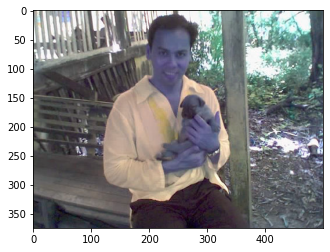

In [23]:
# 確認用
n = 6
xml = ET.parse(val_anno_list[n]).getroot()
for i in xml.iter('object'):
    print(i.find('name').text.upper().strip())
    print([f'{j}:{i.find("bndbox").find(j).text}' for j in ['xmin', 'ymin', 'xmax', 'ymax']])
plt.imshow(cv2.imread(val_img_list[n]))

In [17]:
# 動作確認　
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

transform_anno = Anno_xml2list(voc_classes)

# 画像の読み込み OpenCVを使用
ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得

# アノテーションをリストで表示
transform_anno(val_anno_list[ind], width, height)

array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

### 画像とアノテーションの前処理を行うクラスDataTransformを作成

続いて画像とBounding Boxに対して前処理を行うクラスDataTraansformを作成（学習時と推論時で異なる動作をするように設定）
> 学習時：データオーギュメンテーションを行うように設定(画像を変形させる際にはBounding Boxの情報も変形させる必要がある)
>> 画像とBounding Box同時に変形させるクラスはPytorchには用意されていないので自分で作成する必要がある\
今回は引用のデータオーギュメンテーションクラスを”until”の"data_sugumentation.py"用意し、この前処理クラスをimportする

> 訓練時：データオーギュメンテーション時に色調を変換し、画像の大きさを変更してから、ランダムに切り出す操作を行う。\
さらに画像の大きさをリサイズして色情報の平均値を引き算する
>>推論時は画像の大きさを変換し、色の平均値を引き算するだけ

In [0]:
# フォルダ「utils」にあるdata_augumentation.pyからimport。
# 入力画像の前処理をするクラス
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans

class DataTransform():
    """
    画像とアノテーションの前処理クラス。訓練と推論で異なる動作をする。
    画像のサイズを300x300にする。
    学習時はデータオーギュメンテーションする。
    Attributes
    ----------
    input_size : int
        リサイズ先の画像の大きさ。
    color_mean : (B, G, R)
        各色チャネルの平均値。
    """
    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),  # intをfloat32に変換
                ToAbsoluteCoords(),  # アノテーションデータの規格化を戻す
                PhotometricDistort(),  # 画像の色調などをランダムに変化
                Expand(color_mean),  # 画像のキャンバスを広げる
                RandomSampleCrop(),  # 画像内の部分をランダムに抜き出す
                RandomMirror(),  # 画像を反転させる
                ToPercentCoords(),  # アノテーションデータを0-1に規格化
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ]),
            'val': Compose([
                ConvertFromInts(),  # intをfloatに変換
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ])
        }
    def __call__(self, img, phase, boxes, labels):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img, boxes, labels)

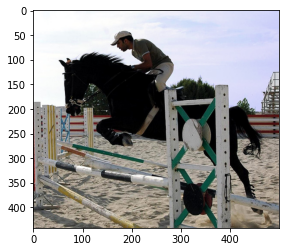

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


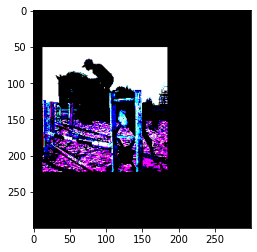

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


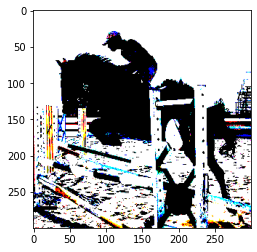

In [19]:
# 動作の確認
# 1. 画像読み込み
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得
# 2. アノテーションをリストに
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)
# 3. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
# 4. 前処理クラスの作成
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする
transform = DataTransform(input_size, color_mean)
# 5. train画像の表示
phase = "train"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()
# 6. val画像の表示
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

### Datasetを作成

In [0]:
# PytorchのクラスDatasetを継承し、クラスVOCDatasetを作成
# クラスAnno_xml2listとクラスDataTransformを利用する
# 関数__getitem__()定義し、前処理した画像のテンソル形式のデータとアノテーションを取得する


class VOCDataset(data.Dataset): # torch.utils.data
    """
    VOC2012のDatasetを作成するクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    img_list : リスト
        画像のパスを格納したリスト
    anno_list : リスト
        アノテーションへのパスを格納したリスト
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    transform : object
        前処理クラスのインスタンス
    transform_anno : object
        xmlのアノテーションをリストに変換するインスタンス
    """

    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase  # train もしくは valを指定
        self.transform = transform  # 画像の変形
        self.transform_anno = transform_anno  # アノテーションデータをxmlからリストへ

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のテンソル形式のデータとアノテーションを取得
        '''
        im, gt, h, w = self.pull_item(index)
        return im, gt

    def pull_item(self, index):
        '''前処理をした画像のテンソル形式のデータ、アノテーション、画像の高さ、幅を取得する'''

        # 1. 画像読み込み
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
        height, width, channels = img.shape  # 画像のサイズを取得

        # 2. xml形式のアノテーション情報をリストに
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)

        # 3. 前処理を実施
        img, boxes, labels = self.transform(
            img, self.phase, anno_list[:, :4], anno_list[:, 4])

        # 色チャネルの順番がBGRになっているので、RGBに順番変更
        # さらに（高さ、幅、色チャネル）の順を（色チャネル、高さ、幅）に変換
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

        # BBoxとラベルをセットにしたnp.arrayを作成、変数名「gt」はground truth（答え）の略称
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

        return img, gt, height, width


In [24]:
# 動作確認
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))


# データの取り出し例
val_dataset.__getitem__(7)

(tensor([[[ -68.5000,  -30.8750,  -63.7917,  ...,  -59.5418,  -63.1250,
            -71.8749],
          [ -92.3333,  -53.6250,  -45.2917,  ...,  -51.5834,  -54.0000,
            -73.1663],
          [ -79.8333,  -89.8750,  -45.7083,  ...,  -74.2917,  -63.3750,
           -104.4164],
          ...,
          [  40.3333,   67.6250,   68.4167,  ...,  -92.9583,  -81.3750,
            -98.7081],
          [  49.7083,   62.6250,   62.3750,  ...,  -83.5835,  -90.1250,
           -108.0831],
          [  56.7500,   80.5000,   79.7083,  ...,  -93.2085, -101.6250,
           -100.1247]],
 
         [[ -81.6667,  -45.5000,  -71.2500,  ...,  -43.2501,  -53.3750,
            -69.4166],
          [ -98.2500,  -63.1250,  -52.4167,  ...,  -45.2500,  -50.0000,
            -71.0413],
          [ -90.9583,  -95.0000,  -55.3333,  ...,  -65.0417,  -54.3750,
            -96.2497],
          ...,
          [  42.9583,   71.3750,   71.6667,  ...,  -83.2084,  -78.2500,
            -98.0832],
          [  53.3

## **3. DataLoaderの実装**

SSDの学習・推論の際に、データをミニバッチとして取り出すためのクラスDataLoaderを実装する。
> SSD固有のものではなく任意の物体検出アルゴリズムにも使用可能

### DataLoaderの作成

画像分類ではPyTorchのDataLoaderクラスを利用するだけでDatasetからDateLoaderを作成することができたが、物体検出の場合はひと工夫必要
> Datasetから取り出すアノテーションデータの情報、変数gtのサイズ（画像内の物体数）が画像ごとに異なる。\
>>画像内の物体数が2個であれば(2, 5)、3個であれば（3, 5）など変化する

> そのためDataLoaderクラスにおいてデフォルトで使用されるデータ取り出し関数であるcollate_fnを別途作成する必要がある


In [0]:
def od_collate_fn(batch): # Object Detection
    """
    collate_fnは、PyTorchでリストからmini-batchを作成する関数。
    ミニバッチ分の画像が並んでいるリスト変数batchに、
    ミニバッチ番号を指定する次元を先頭に1つ追加して、リストの形を変形する
    """
    # targetsはアノテーションデータの正解であるgt
    # リスト要素は [n, [xmin, ymin, xmax, ymax, class_index]]:nは画像内にある物体の数
    targets = [] 
    # imgsはミニバッチサイズのリスト
    # リストの要素はtorch.Size([3, 300, 300])
    # このリストをtorch.Size([batch_num, 3, 300, 300])のテンソルに変換
    imgs = [] 
    for sample in batch:
        imgs.append(sample[0])  # sample[0] は画像img
        targets.append(torch.FloatTensor(sample[1]))  # sample[1] はアノテーションgt

    imgs = torch.stack(imgs, dim=0)

    return imgs, targets

In [26]:
# データローダーの作成
batch_size = 4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作の確認
batch_iterator = iter(dataloaders_dict["val"])  # イタレータに変換
images, targets = next(batch_iterator)  # 1番目の要素を取り出す
print(images.size())  # torch.Size([4, 3, 300, 300])
print(len(targets))
print(targets[1].size())  # ミニバッチのサイズのリスト、各要素は[n, 5]、nは物体数

torch.Size([4, 3, 300, 300])
4
torch.Size([2, 5])


In [27]:
# データの長さの確認
print(train_dataset.__len__())
print(val_dataset.__len__())

5717
5823


## **4.ネットワークモデルの実装**

In [0]:
# パッケージのimport
import pandas as pd
from math import sqrt as sqrt
from itertools import product as product

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Function

In [0]:
# 34層にわたる、vggモジュールを作成
def make_vgg():
    layers = []
    in_channels = 3  # 色チャネル数

    # vggモジュールで使用する畳み込み層やマックスプーリングのチャネル数
    cfg = [64, 64, 'M', 128, 128, 'M', 256, 256,
           256, 'MC', 512, 512, 512, 'M', 512, 512, 512]

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'MC':
            # ceilは出力サイズを、計算結果（float）に対して、切り上げで整数にするモード
            # デフォルトでは出力サイズを計算結果（float）に対して、切り下げで整数にするfloorモード
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6,
               nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return nn.ModuleList(layers)


# 動作確認
vgg_test = make_vgg()
print(vgg_test)


## **5.順伝搬関数の実装**

## **6.損失関数の実装**

## **7.学習の検証と実施**

## 8. 推論の実施

## 9.参考書籍



小山雄太郎, つくりながら学ぶ！PyTorchによる発展ディープラーニング, 株式会社マイナビ出版, 2019, p58-128